In [2]:
import cv2
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from skimage.feature import local_binary_pattern

In [3]:
# Function to convert RGB image to HSI
def rgb_to_hsi(image):
    hsi_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return hsi_image

# Function for GrabCut segmentation
def segment_tyre(image):
    # Convert image to HSI
    hsi_image = rgb_to_hsi(image)

    # Extract hue component
    hue = hsi_image[:, :, 0]

    # Thresholding on hue channel to separate tyre from background
    _, binary_mask = cv2.threshold(hue, 30, 255, cv2.THRESH_BINARY)

    # Perform morphological operations to refine the mask
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed algorithm
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]  # Mark watershed boundary on original image

    # Convert markers to binary mask
    mask = np.zeros_like(binary_mask)
    mask[markers > 1] = 255  # Mark region other than background

    # Apply the mask to original image
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    return segmented_image

# Function for LBP feature extraction
def extract_features(image):
    
    hsi_image = rgb_to_hsi(image)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Compute Local Binary Pattern
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    # Calculate histogram of LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    return hist

# Function to load images from folders
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
# Load good and  Defective Tyre images
good_folder = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\For SVM\good tyre image"
defective_folder = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\For SVM\defective tyre image"

good_images = load_images_from_folder(good_folder)
defective_images = load_images_from_folder(defective_folder)

# Segment and extract features for good images
good_features = []
for img in good_images:
    segmented_img = segment_tyre(img)
    features = extract_features(segmented_img)
    good_features.append(features)

# Segment and extract features for defective images
defective_features = []
for img in defective_images:
    segmented_img = segment_tyre(img)
    features = extract_features(segmented_img)
    defective_features.append(features)

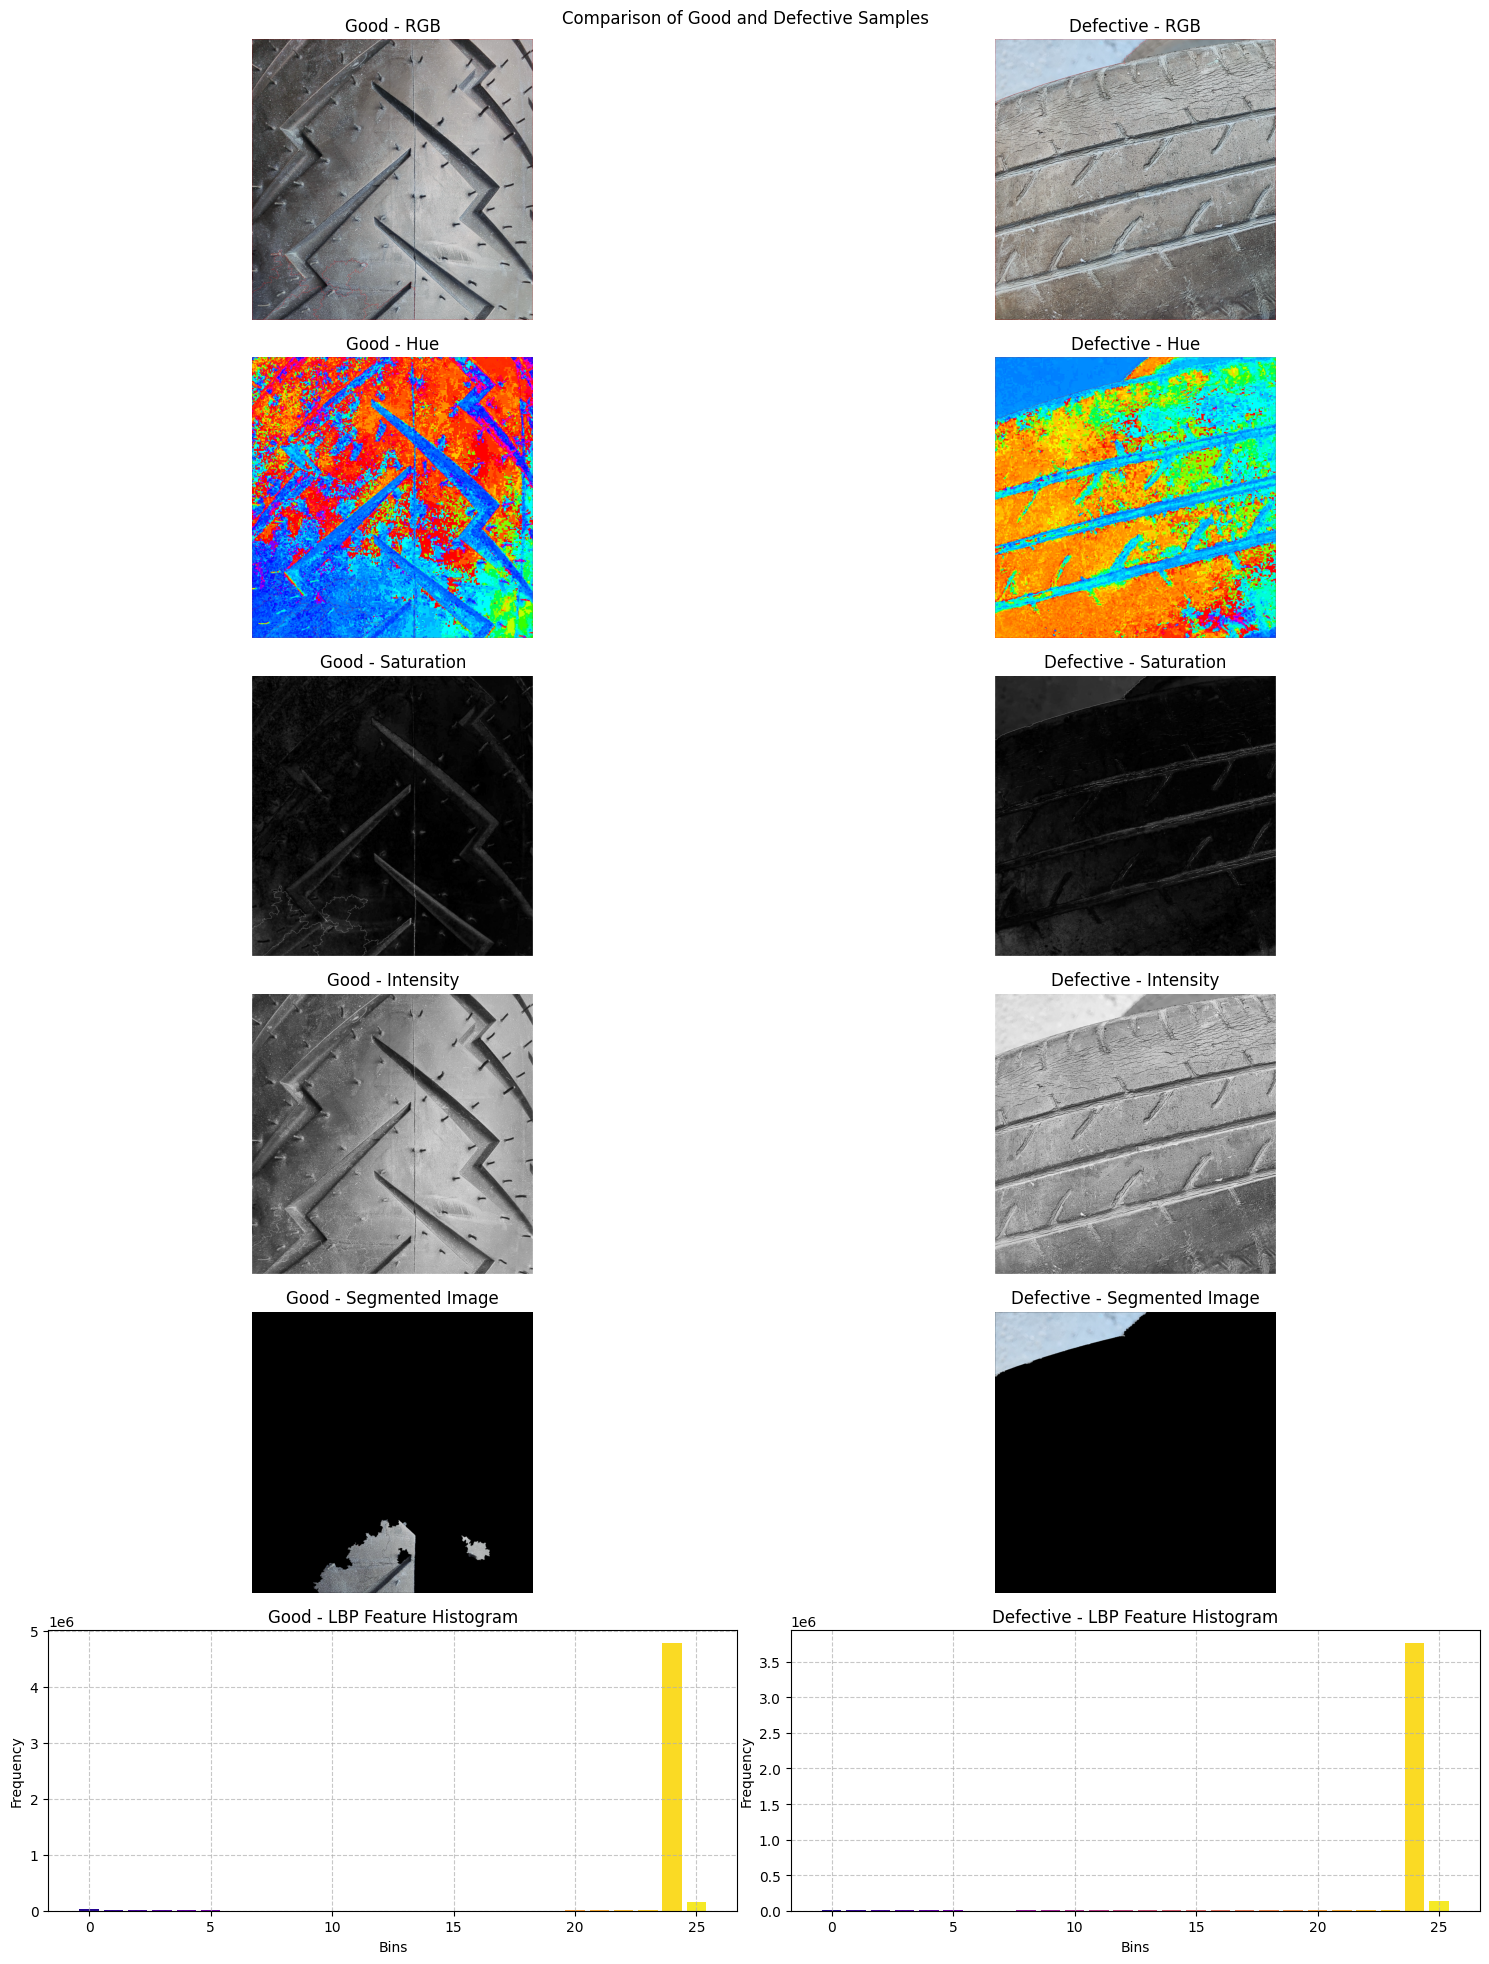

In [5]:
# Function to visualize HSI conversion and extracted features for a sample image
def visualize_samples(good_image, defective_image):
    fig, axes = plt.subplots(6, 2, figsize=(15, 20))

    # Visualize good image
    axes[0, 0].imshow(good_image)
    axes[0, 0].set_title('Good - RGB')
    axes[0, 0].axis('off')

    axes[1, 0].imshow(rgb_to_hsi(good_image)[:, :, 0], cmap='hsv')
    axes[1, 0].set_title('Good - Hue')
    axes[1, 0].axis('off')

    axes[2, 0].imshow(rgb_to_hsi(good_image)[:, :, 1], cmap='gray')
    axes[2, 0].set_title('Good - Saturation')
    axes[2, 0].axis('off')

    axes[3, 0].imshow(rgb_to_hsi(good_image)[:, :, 2], cmap='gray')
    axes[3, 0].set_title('Good - Intensity')
    axes[3, 0].axis('off')

    segmented_img_good = segment_tyre(good_image)
    features_good = extract_features(segmented_img_good)

    axes[4, 0].imshow(segmented_img_good)
    axes[4, 0].set_title('Good - Segmented Image')
    axes[4, 0].axis('off')

    num_bins_good = len(features_good)
    colors_good = sns.color_palette("plasma", num_bins_good)

    axes[5, 0].bar(range(num_bins_good), features_good, color=colors_good)
    axes[5, 0].set_title('Good - LBP Feature Histogram')
    axes[5, 0].set_xlabel('Bins')
    axes[5, 0].set_ylabel('Frequency')
    axes[5, 0].grid(True, linestyle='--', alpha=0.7)

    # Visualize defective image
    axes[0, 1].imshow(defective_image)
    axes[0, 1].set_title('Defective - RGB')
    axes[0, 1].axis('off')

    axes[1, 1].imshow(rgb_to_hsi(defective_image)[:, :, 0], cmap='hsv')
    axes[1, 1].set_title('Defective - Hue')
    axes[1, 1].axis('off')

    axes[2, 1].imshow(rgb_to_hsi(defective_image)[:, :, 1], cmap='gray')
    axes[2, 1].set_title('Defective - Saturation')
    axes[2, 1].axis('off')

    axes[3, 1].imshow(rgb_to_hsi(defective_image)[:, :, 2], cmap='gray')
    axes[3, 1].set_title('Defective - Intensity')
    axes[3, 1].axis('off')

    segmented_img_defective = segment_tyre(defective_image)
    features_defective = extract_features(segmented_img_defective)

    axes[4, 1].imshow(segmented_img_defective)
    axes[4, 1].set_title('Defective - Segmented Image')
    axes[4, 1].axis('off')

    num_bins_defective = len(features_defective)
    colors_defective = sns.color_palette("plasma", num_bins_defective)

    axes[5, 1].bar(range(num_bins_defective), features_defective, color=colors_defective)
    axes[5, 1].set_title('Defective - LBP Feature Histogram')
    axes[5, 1].set_xlabel('Bins')
    axes[5, 1].set_ylabel('Frequency')
    axes[5, 1].grid(True, linestyle='--', alpha=0.7)

    plt.suptitle("Comparison of Good and Defective Samples")
    plt.tight_layout()
    plt.show()

# Visualize a sample image from the good dataset and the defective dataset
visualize_samples(good_images[0], defective_images[0])

In [6]:
# Create dataframes for Good  and Defective features
good_df = pd.DataFrame(good_features)
defective_df = pd.DataFrame(defective_features)

# Label good as 0 and defective as 1
good_df['label'] = 0
defective_df['label'] = 1

# Combine dataframes
df = pd.concat([good_df, defective_df], ignore_index=True)

In [7]:
df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,label
0,32883,10233,13003,12046,8545,5540,3887,3141,2725,2633,...,2380,2826,3478,5133,8604,12435,12529,4709693,191451,0
1,140813,57451,57637,47032,36504,29274,24910,23000,23536,25516,...,20258,19521,23234,31500,46382,59823,57191,3010634,1038621,0
2,28911,17702,14206,11188,9498,8332,7585,8575,9103,10844,...,8304,7398,7782,8900,12324,16168,17631,2596699,345066,0
3,52106,20523,20861,19183,17275,16168,15802,16922,18607,21967,...,13248,11956,12776,14233,18468,21955,19960,4146059,392062,0
4,77864,30701,31444,28168,26072,25472,26350,28785,32914,37696,...,21638,19543,20008,21782,27918,32085,29628,3656624,603496,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,7811,4425,3143,2177,1559,1336,1247,1494,1853,2220,...,2003,1420,1485,1784,2588,3685,3512,4922177,72254,1
236,5835,1902,2208,2043,1745,1515,1298,1270,1261,1300,...,1107,1086,1222,1545,1987,2099,1690,4987831,33554,1
237,3993,2253,1692,1359,979,864,704,822,994,1275,...,1021,795,961,1174,1715,2068,1794,4987741,39032,1
238,18938,11455,9088,7244,6100,5823,5635,7800,10796,14792,...,12853,8685,9207,11095,13424,16136,10925,4471617,231283,1


In [8]:
# Model fitting
X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM model
svm_model = SVC()
svm_model.probability = True
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [9]:
# Model evaluation
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6458333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        24
           1       0.68      0.54      0.60        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.64        48
weighted avg       0.65      0.65      0.64        48



In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_decision_tree))
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_decision_tree))

# Random Forest
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_random_forest))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_random_forest))

# Linear Discriminant Analysis (LDA)
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

# Naive Bayes
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_naive_bayes))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_naive_bayes))

Logistic Regression Accuracy: 0.75
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.80      0.67      0.73        24

    accuracy                           0.75        48
   macro avg       0.76      0.75      0.75        48
weighted avg       0.76      0.75      0.75        48

KNN Accuracy: 0.6666666666666666
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        24
           1       0.67      0.67      0.67        24

    accuracy                           0.67        48
   macro avg       0.67      0.67      0.67        48
weighted avg       0.67      0.67      0.67        48

Decision Tree Accuracy: 0.6458333333333334
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67        24
           1       

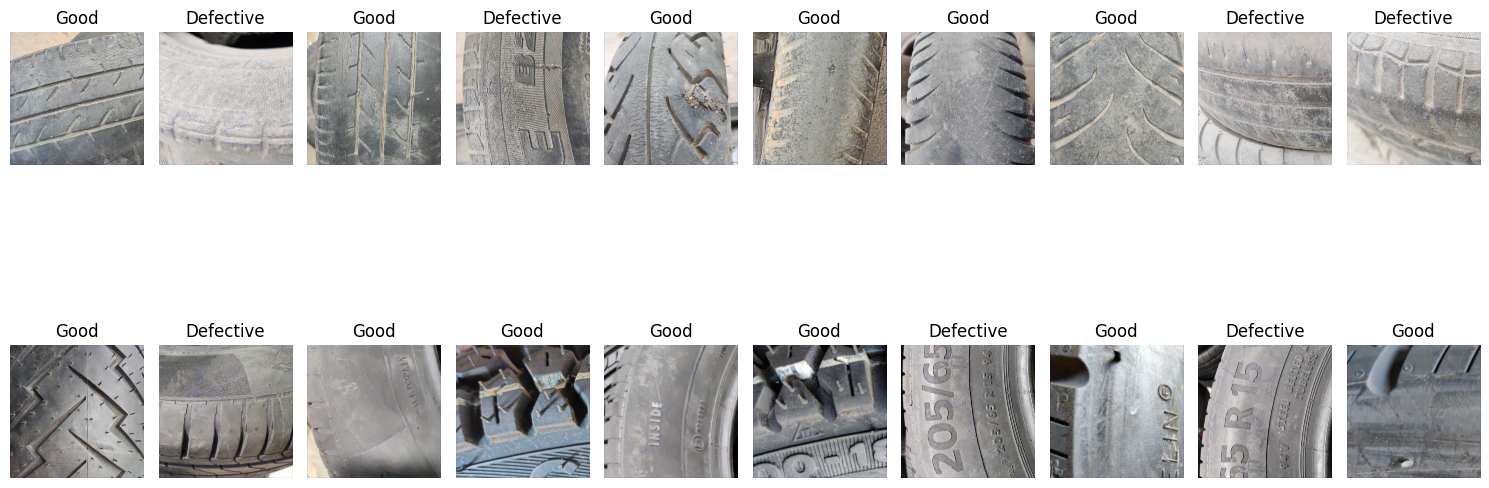

In [11]:
# Function to display original images with labels in rows
def show_original_images_with_labels_in_rows(images, labels, num_rows=2):
    num_images_per_row = math.ceil(len(images) / num_rows)
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 8))
    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < len(images):
                axes[i, j].imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(labels[index])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Load images from the test folder
test_folder = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\For SVM\Test image of tyre image"
test_images = load_images_from_folder(test_folder)

# Scale the test images using the same scaler used during training
scaled_test_images = []

for img in test_images:
    # Segment the tyre region
    segmented_img = segment_tyre(img)
    
    # Extract features from segmented image
    features = extract_features(segmented_img)
    
    # Scale the features
    scaled_features = scaler.transform([features])  # Assuming 'scaler' is your StandardScaler object
    
    # Make predictions
    prediction = svm_model.predict(scaled_features)[0]
    scaled_test_images.append("Defective" if prediction == 1 else "Good")  # Mapping 0 and 1 to Good and Defective

# Display original test images with predicted labels in two rows
show_original_images_with_labels_in_rows(test_images, scaled_test_images, num_rows=2)

In [12]:
# Defining parameter ranges for different kernels
param_grid = {
    'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'rbf', 'sigmoid']
} 

# Create GridSearchCV object
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, refit=True, verbose=3) 

# Fit the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 147 candidates, totalling 735 fits
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.487 total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.0001, kernel=linear;, score=0.500 total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.487 total time=   0.0s
[CV 3/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=0.0001, kernel=rbf;, score=0.474 total time=   0.0s
[CV 1/5] END C=0.0001, gamma=0.0001, kernel=sigmoid;, score=0.487 total time=   0.0s
[CV 2/5] END C=0.0001, gamm

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             verbose=3)

In [13]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
SVC(C=100, gamma=0.0001, kernel='linear', probability=True)


In [14]:
# Get the best hyperparameters and model
best_params = grid.best_params_
best_model = grid.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVM Accuracy: {accuracy_best:.2f}")
print(f"Best Hyperparameters: {best_params}")

Best SVM Accuracy: 0.81
Best Hyperparameters: {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}


In [15]:
# Model evaluation
y_pred_best = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best)
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        24
           1       0.86      0.75      0.80        24

    accuracy                           0.81        48
   macro avg       0.82      0.81      0.81        48
weighted avg       0.82      0.81      0.81        48



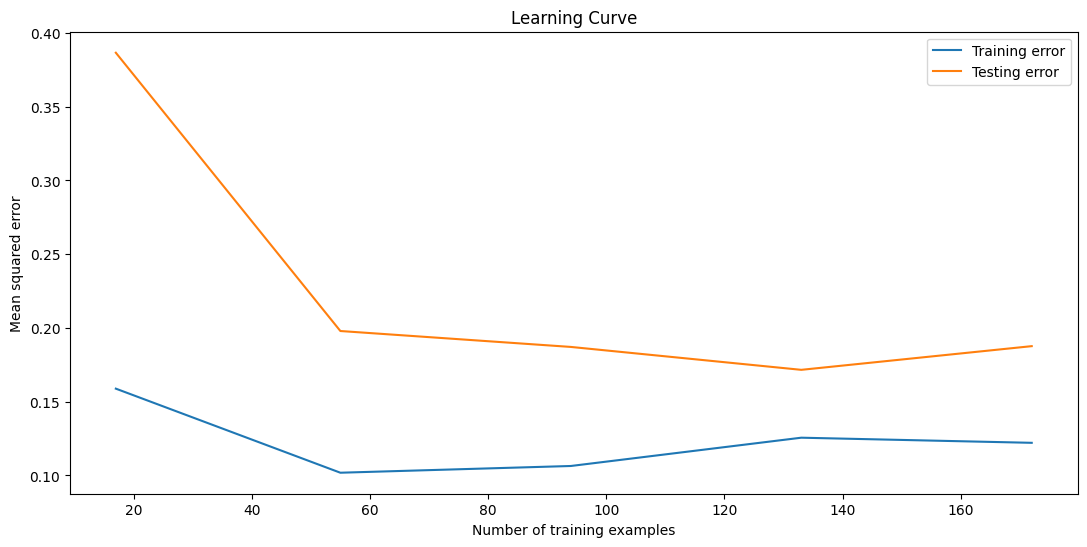

In [16]:
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculate mean training and testing error
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(13, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Testing error')
plt.xlabel('Number of training examples')
plt.ylabel('Mean squared error')
plt.title('Learning Curve')
plt.legend()
plt.grid(False)
plt.show()

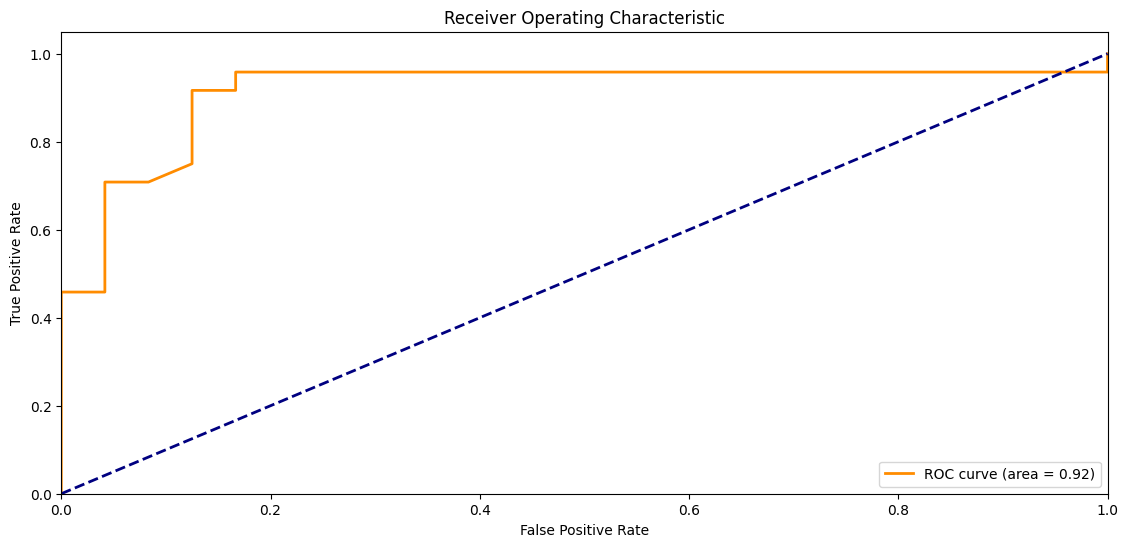

In [17]:
# ROC analysis
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(13.5, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
roc_auc

0.9157986111111112

In [20]:
## 1. 🚀 Logistic Regression with Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000))
])

logreg_params = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['liblinear', 'lbfgs']
}

logreg_grid = GridSearchCV(logreg_pipeline, logreg_params, cv=5, scoring='recall_macro')
logreg_grid.fit(X_train, y_train)
y_pred = logreg_grid.predict(X_test)

print("Best Logistic Regression Params:", logreg_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Logistic Regression Params: {'logreg__C': 10, 'logreg__solver': 'liblinear'}
Accuracy: 0.8541666666666666
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        24
           1       0.87      0.83      0.85        24

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48



In [21]:
## 2. 🧭 K-Nearest Neighbors (KNN) with Scaling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5, scoring='recall_macro')
knn_grid.fit(X_train, y_train)
y_pred = knn_grid.predict(X_test)

print("Best KNN Params:", knn_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best KNN Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        24
           1       0.62      0.62      0.62        24

    accuracy                           0.62        48
   macro avg       0.62      0.62      0.62        48
weighted avg       0.62      0.62      0.62        48



In [22]:
## 3. 🌳 Decision Tree with Class Weight
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5, scoring='recall_macro')
tree_grid.fit(X_train, y_train)
y_pred = tree_grid.predict(X_test)

print("Best Decision Tree Params:", tree_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Decision Tree Params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5}
Accuracy: 0.6041666666666666
              precision    recall  f1-score   support

           0       0.59      0.67      0.63        24
           1       0.62      0.54      0.58        24

    accuracy                           0.60        48
   macro avg       0.61      0.60      0.60        48
weighted avg       0.61      0.60      0.60        48



In [23]:
## 4. 🌲 Random Forest with Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='recall_macro')
rf_grid.fit(X_train, y_train)
y_pred = rf_grid.predict(X_test)

print("Best Random Forest Params:", rf_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Random Forest Params: {'class_weight': None, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.5416666666666666
              precision    recall  f1-score   support

           0       0.54      0.62      0.58        24
           1       0.55      0.46      0.50        24

    accuracy                           0.54        48
   macro avg       0.54      0.54      0.54        48
weighted avg       0.54      0.54      0.54        48



In [26]:
## 5. 📈 LDA with Scaling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

lda_pipeline.fit(X_train, y_train)
y_pred = lda_pipeline.predict(X_test)

print("LDA Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

LDA Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        24
           1       0.88      0.88      0.88        24

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.88        48
weighted avg       0.88      0.88      0.88        48



In [27]:
## 6. 🎯 Naive Bayes with Scaling
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional; NB is less sensitive
    ('nb', GaussianNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred = nb_pipeline.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Naive Bayes Accuracy: 0.6041666666666666
              precision    recall  f1-score   support

           0       0.57      0.83      0.68        24
           1       0.69      0.38      0.49        24

    accuracy                           0.60        48
   macro avg       0.63      0.60      0.58        48
weighted avg       0.63      0.60      0.58        48



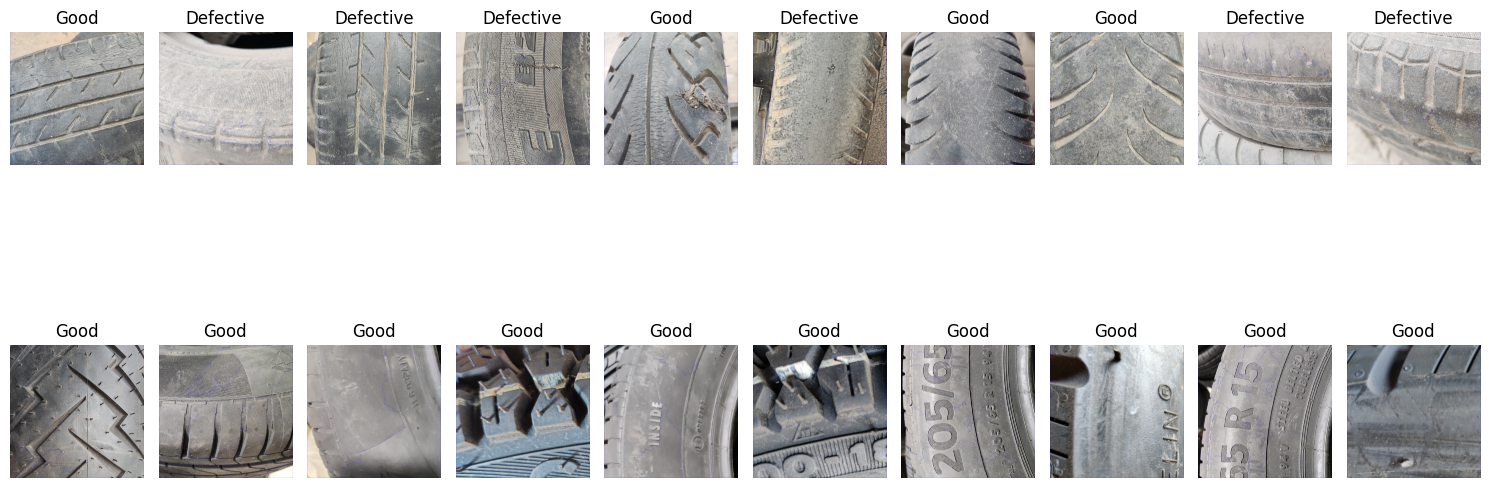

In [25]:
# Function to display original images with labels in rows
def show_original_images_with_labels_in_rows(images, labels, num_rows=2):
    num_images_per_row = math.ceil(len(images) / num_rows)
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 8))
    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < len(images):
                axes[i, j].imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(labels[index])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Load images from the test folder
test_folder = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\For SVM\Test image of tyre image"
test_images = load_images_from_folder(test_folder)

# Scale the test images using the same scaler used during training
scaled_test_images = []

for img in test_images:
    # Segment the tyre region
    segmented_img = segment_tyre(img)
    
    # Extract features from segmented image
    features = extract_features(segmented_img)
    
    # Scale the features
    scaled_features = scaler.transform([features])  # Assuming 'scaler' is your StandardScaler object
    
    # Make predictions
    prediction = best_model.predict(scaled_features)[0]
    scaled_test_images.append("Defective" if prediction == 1 else "Good")  # Mapping 0 and 1 to Good and Defective

# Display original test images with predicted labels in two rows
show_original_images_with_labels_in_rows(test_images, scaled_test_images, num_rows=2)

SVM Accuracy: 0.6458333333333334
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        24
           1       0.68      0.54      0.60        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.64        48
weighted avg       0.65      0.65      0.64        48



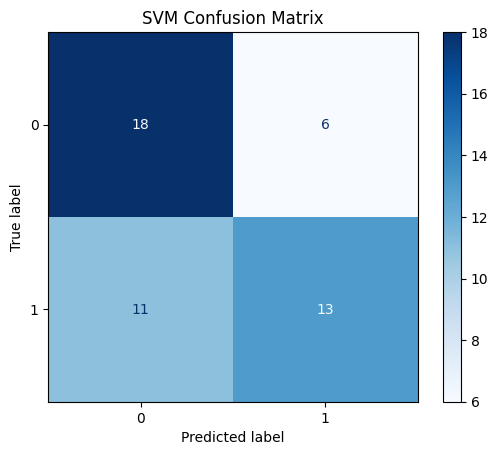

In [28]:
# SVM
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
svm_cm = confusion_matrix(y_test, y_pred_svm)
#ConfusionMatrixDisplay(svm_cm, "SVM")
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
disp.plot(cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.show()

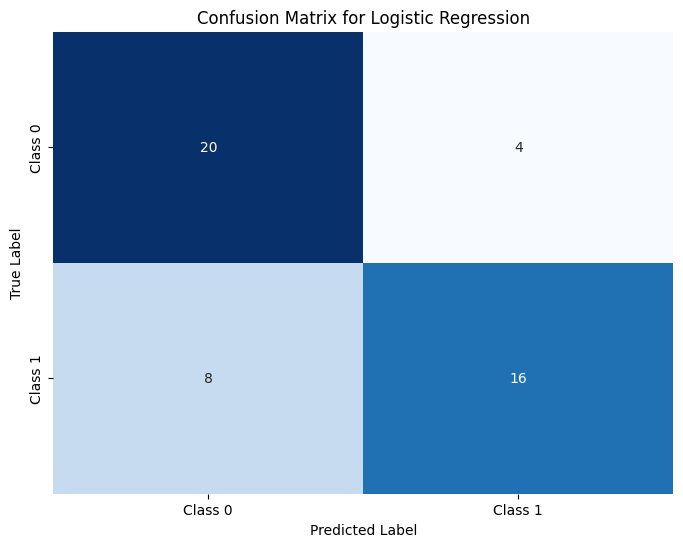

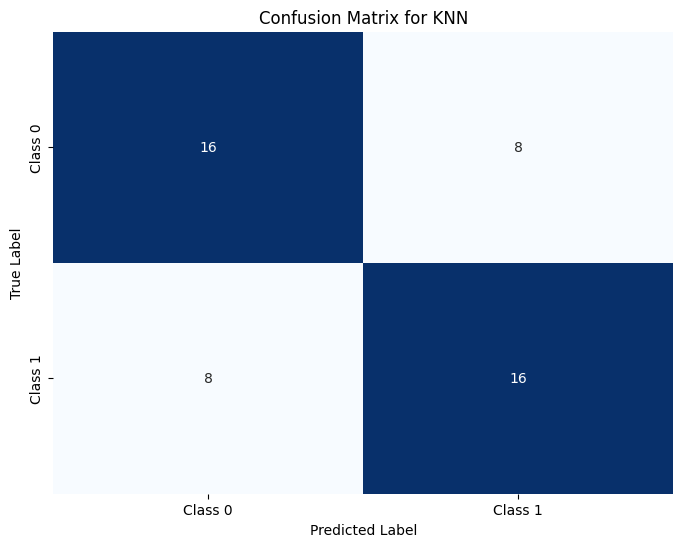

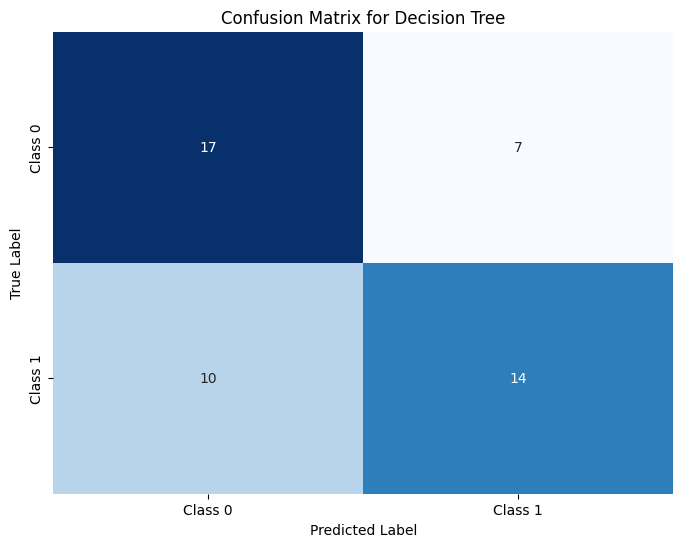

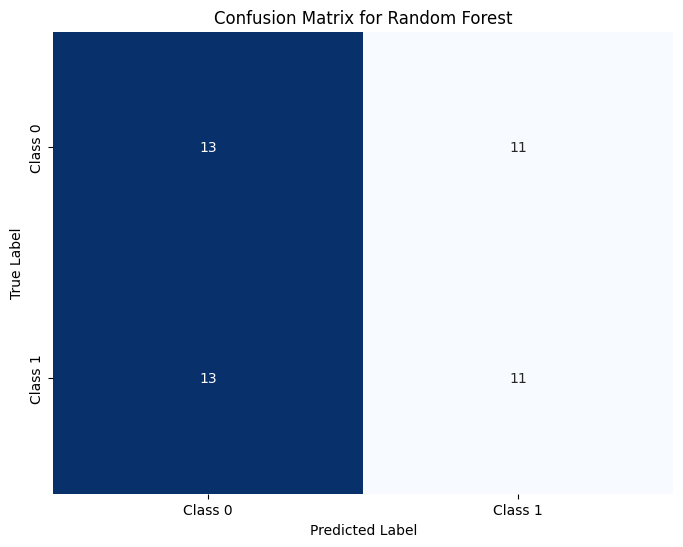

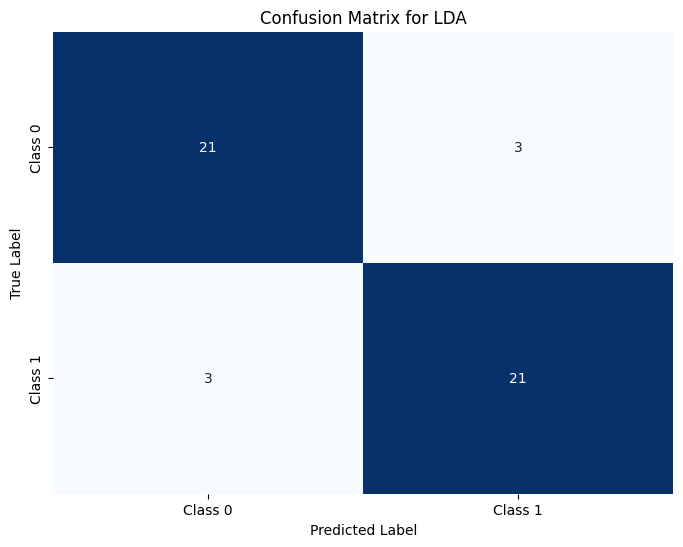

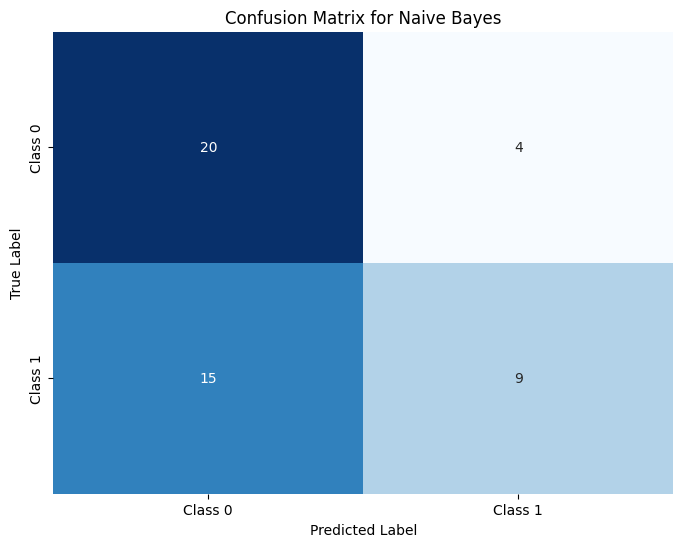

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


logistic_cm = confusion_matrix(y_test, y_pred_logistic)
plot_confusion_matrix(logistic_cm, "Logistic Regression")   

knn_cm = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(knn_cm, "KNN")

decision_tree_cm = confusion_matrix(y_test, y_pred_decision_tree)
plot_confusion_matrix(decision_tree_cm, "Decision Tree")

random_forest_cm = confusion_matrix(y_test, y_pred_random_forest)
plot_confusion_matrix(random_forest_cm, "Random Forest")

lda_cm = confusion_matrix(y_test, y_pred_lda)
plot_confusion_matrix(lda_cm, "LDA")

naive_bayes_cm = confusion_matrix(y_test, y_pred_naive_bayes)
plot_confusion_matrix(naive_bayes_cm, "Naive Bayes")

In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset paths
dataset_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"
good_tire_path = os.path.join(dataset_path, "Good")  # Folder with good tires
defective_tire_path = os.path.join(dataset_path, "Defective")  # Folder with defective tires

# Image settings
IMG_SIZE = 128  # Resize all images to 128x128
BATCH_SIZE = 32

# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(label)
    return images, labels

# Load dataset
good_images, good_labels = load_images_from_folder(good_tire_path, 0)  # Label 0 = Good Tire
defective_images, defective_labels = load_images_from_folder(defective_tire_path, 1)  # Label 1 = Defective Tire

# Combine and convert to NumPy arrays
X = np.array(good_images + defective_images)
y = np.array(good_labels + defective_labels)

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation for better learning
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Good vs. Defective)
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), epochs=10, validation_data=(X_test, y_test))

# Save trained model
model.save("tire_defect_detector.h5")

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Function to predict new tire image
def predict_tire(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img = np.expand_dims(img, axis=0)  # Reshape for model
    prediction = model.predict(img)[0][0]
    return "Defective Tire" if prediction > 0.25 else "Good Tire"

# Test prediction
#test_image = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\test image\Defective (1).jpg"
test_image = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\testing image for tyre datasets\good (42).jpg"
print(f"Prediction for test image: {predict_tire(test_image)}")
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict labels on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.25).astype(int).flatten()

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 Classification Metrics:")
print(f"Accuracy  : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1 Score  : {f1:.2f}")

# Optional: full classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Good Tire", "Defective Tire"]))

Epoch 1/10
43/43 [==============================] - 44s 949ms/step - loss: 0.7064 - accuracy: 0.5994 - val_loss: 0.8206 - val_accuracy: 0.5647
Epoch 2/10
43/43 [==============================] - 41s 942ms/step - loss: 0.5660 - accuracy: 0.7180 - val_loss: 0.4808 - val_accuracy: 0.7559
Epoch 3/10
43/43 [==============================] - 42s 972ms/step - loss: 0.5368 - accuracy: 0.7423 - val_loss: 0.4712 - val_accuracy: 0.7735
Epoch 4/10
43/43 [==============================] - 41s 938ms/step - loss: 0.5174 - accuracy: 0.7555 - val_loss: 0.4502 - val_accuracy: 0.7941
Epoch 5/10
43/43 [==============================] - 42s 961ms/step - loss: 0.4926 - accuracy: 0.7592 - val_loss: 0.5645 - val_accuracy: 0.7324
Epoch 6/10
43/43 [==============================] - 40s 915ms/step - loss: 0.5036 - accuracy: 0.7614 - val_loss: 0.8717 - val_accuracy: 0.6588
Epoch 7/10
43/43 [==============================] - 37s 859ms/step - loss: 0.4978 - accuracy: 0.7577 - val_loss: 0.5334 - val_accuracy: 0.7412

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 3s 219ms/step - loss: 0.5045 - accuracy: 0.7618
Test Accuracy: 0.76
1/1 [==============================] - 0s 275ms/step
Prediction for test image: Good Tire
11/11 [==============================] - 2s 211ms/step

📊 Classification Metrics:
Accuracy  : 0.79
Precision : 0.76
Recall    : 0.84
F1 Score  : 0.79

Detailed Classification Report:
                precision    recall  f1-score   support

     Good Tire       0.83      0.75      0.79       176
Defective Tire       0.76      0.84      0.79       164

      accuracy                           0.79       340
     macro avg       0.79      0.79      0.79       340
  weighted avg       0.79      0.79      0.79       340



In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

11/11 [==============================] - 2s 217ms/step - loss: 0.4526 - accuracy: 0.7735
Test Accuracy: 0.77


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict labels on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.25).astype(int).flatten()

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 Classification Metrics:")
print(f"Accuracy  : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1 Score  : {f1:.2f}")

# Optional: full classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Good Tire", "Defective Tire"]))

11/11 [==============================] - 3s 228ms/step

📊 Classification Metrics:
Accuracy  : 0.71
Precision : 0.62
Recall    : 1.00
F1 Score  : 0.77

Detailed Classification Report:
                precision    recall  f1-score   support

     Good Tire       1.00      0.43      0.60       176
Defective Tire       0.62      1.00      0.77       164

      accuracy                           0.71       340
     macro avg       0.81      0.72      0.68       340
  weighted avg       0.82      0.71      0.68       340



In [7]:
import pandas as pd 
# Predict an entire folder of images
test_folder_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\testing image for tyre datasets"
valid_extensions = (".jpg", ".jpeg", ".png")
results = []

print("\n📢 Batch Predictions:")
for filename in os.listdir(test_folder_path):
    if filename.lower().endswith(valid_extensions):
        file_path = os.path.join(test_folder_path, filename)
        prediction = predict_tire(file_path)
        print(f"{filename} → {prediction}")
        results.append({'filename': filename, 'prediction': prediction})

# Optional: Save predictions to CSV
df = pd.DataFrame(results)
df.to_csv("tire_test_predictions.csv", index=False)
print("\n✅ Predictions saved to 'tire_test_predictions(2).csv'")
valid_extensions = (".jpg", ".jpeg", ".png")
results = []

print("\n📢 Batch Predictions:")
for filename in os.listdir(test_folder_path):
    if filename.lower().endswith(valid_extensions):
        file_path = os.path.join(test_folder_path, filename)
        prediction = predict_tire(file_path)
        print(f"{filename} → {prediction}")
        results.append({'filename': filename, 'prediction': prediction})

# Optional: Save predictions to CSV
df = pd.DataFrame(results)
df.to_csv("tire_test_predictions.csv", index=False)
print("\n✅ Predictions saved to 'tire_test_predictions.csv'")


📢 Batch Predictions:
1/1 [==============================] - 0s 62ms/step
Defective (1).jpg → Defective Tire
1/1 [==============================] - 0s 78ms/step
Defective (10).jpg → Defective Tire
1/1 [==============================] - 0s 75ms/step
Defective (100).jpg → Defective Tire
1/1 [==============================] - 0s 74ms/step
Defective (11).jpg → Defective Tire
1/1 [==============================] - 0s 83ms/step
Defective (12).jpg → Defective Tire
1/1 [==============================] - 0s 75ms/step
Defective (13).jpg → Defective Tire
1/1 [==============================] - 0s 80ms/step
Defective (14).jpg → Defective Tire
1/1 [==============================] - 0s 78ms/step
Defective (15).jpg → Defective Tire
1/1 [==============================] - 0s 78ms/step
Defective (16).jpg → Defective Tire
1/1 [==============================] - 0s 216ms/step
Defective (17).jpg → Defective Tire
1/1 [==============================] - 0s 68ms/step
Defective (18).jpg → Defective Tire
1/1 [====

In [8]:
# Folder to save annotated prediction images
output_folder = "annotated_predictions"
os.makedirs(output_folder, exist_ok=True)

# Font settings for cv2.putText
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (0, 255, 0)
font_thickness = 2

print("\n🖼️ Annotating images with predictions...")

for filename in os.listdir(test_folder_path):
    if filename.lower().endswith(valid_extensions):
        file_path = os.path.join(test_folder_path, filename)
        prediction = predict_tire(file_path)

        # Read original image
        img = cv2.imread(file_path)
        if img is not None:
            # Resize for consistent display (optional)
            img = cv2.resize(img, (400, 400))

            # Choose color based on prediction
            color = (0, 255, 0) if prediction == "Good Tire" else (0, 0, 255)

            # Put prediction text on image
            cv2.putText(img, prediction, (10, 30), font, font_scale, color, font_thickness)

            # Save the image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, img)

print(f"\n✅ Annotated images saved to: {os.path.abspath(output_folder)}")


🖼️ Annotating images with predictions...
1/1 [==============================] - 0s 72ms/step

✅ Annotated images saved to: C:\Users\dubey\annotated_predictions


In [9]:
# Display the first 3 annotated images
for i, file in enumerate(os.listdir(output_folder)):
    if file.lower().endswith(valid_extensions) and i < 10:
        img = cv2.imread(os.path.join(output_folder, file))
        cv2.imshow(f"Prediction: {file}", img)
        cv2.waitKey(0)
cv2.destroyAllWindows()